In [4]:
import pandas as pd
from scipy.spatial.distance import pdist, jaccard
from scipy.stats import pearsonr,spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d
from scipy.spatial.distance import correlation,cosine
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import numpy as np
from seaborn import heatmap
%matplotlib inline

In [22]:
df1 = pd.read_csv('../spectra/Sample Plots Raw batch 1.csv',delimiter="\t")
df2 = pd.read_csv('../spectra/Sample Plots Raw batch 2.csv',delimiter="\t")
df3 = pd.read_csv('../spectra/Sample Plots Raw batch 3.csv',delimiter="\t")

In [23]:
df1 = df1[(df1['kDa']>=1.9) & (df1['kDa']<=41)]
df2 = df2[(df2['kDa']>=1.9) & (df2['kDa']<=41)]
df3 = df3[(df3['kDa']>=1.9) & (df3['kDa']<=41)]

In [53]:
def buildDataframe(dfList,dfNames):
    
    samples = []
    names = []
    samples.append(np.arange(2.0,40,0.1))
    names.append('points')
    for df,name in zip(dfList,dfNames):
        columns = df.columns[1:]
        for c in columns:
            f = interp1d(df['kDa'],df[c])
            samples.append(f(np.arange(2.0,40,0.1)))
            names.append(name+'-'+c)
    
    return pd.DataFrame(data=np.transpose(samples),columns=names,index=None)

In [56]:
newdf = buildDataframe([df1,df2,df3],['batch1','batch2','batch3'])

In [57]:
def generate_spectra(df):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
         A dataframe where the first row contains the names of the samples and for each sample we have its spectra
    
    Returns
    ----------
    matrix : narray
             The spectra associated with each sample
    names  : list
             The list of names of the samples
    """
    
    names = df.columns[1:]
        
    
    return np.transpose(df.values[:,1:]), names   

In [58]:
def compute_distance(vector1,vector2,metric='correlation'):
    if(metric=='correlation'):
        return correlation(vector1,vector2)
    if(metric=='cosine'):
        return cosine(vector1,vector2)

In [59]:
def generate_similarity_matrix(df,metric='correlation'):
    # We group the mws of each sample
    spectra,names = generate_spectra(df)
    
    matrix  = np.zeros((len(names),len(names)),dtype='float32')
    for i in range(0,len(names)):
        for j in range(i+1,len(names)):
            matrix[i][j] = compute_distance(spectra[i],
                                            spectra[j],
                                            metric)
            matrix[j][i] = matrix[i][j]
    return matrix, names

In [60]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [61]:
def generate_dendogram(df,linkage='average',metric='correlation',threshold=0.35,name='dendogram.jpg'):
    """
    Generate occurrence matrix from dataframe
    
    Parameters
    ----------
    df : dataframe
        A dataframe where the first column contains the names of the samples and the second
        contains the molecular weights
    linkage: string
        The linkage method for building the dendogram:
        ‘ward’, ‘complete’, ‘average’, ‘single’.
    metric: string
        One of the following metrics to compute the distance matrix:
        'pearson' or 'spearman'
    threshold: float >=0 and <=1
        Value that is considered to create a cluster. 
    name: string
        Path where the dendogram will be saved
    Returns
    ----------
    This methods shows the associated dendogram and saves the image.
    """

    if(metric=='correlation' or metric=='cosine'):            
        m,names = generate_similarity_matrix(df,metric)
    else:
        raise Excepction('Only jaccard and dice are supported')
    
    clustering = AgglomerativeClustering(n_clusters=None,affinity='precomputed',linkage=linkage,
                                      distance_threshold=threshold)
    clustering.fit(m)
    
    plt.figure(figsize=(50, 2*len(names)))
    plot_dendrogram(clustering,leaf_font_size=1.25*len(names),orientation='left',labels = names)
    plt.savefig(name)
    

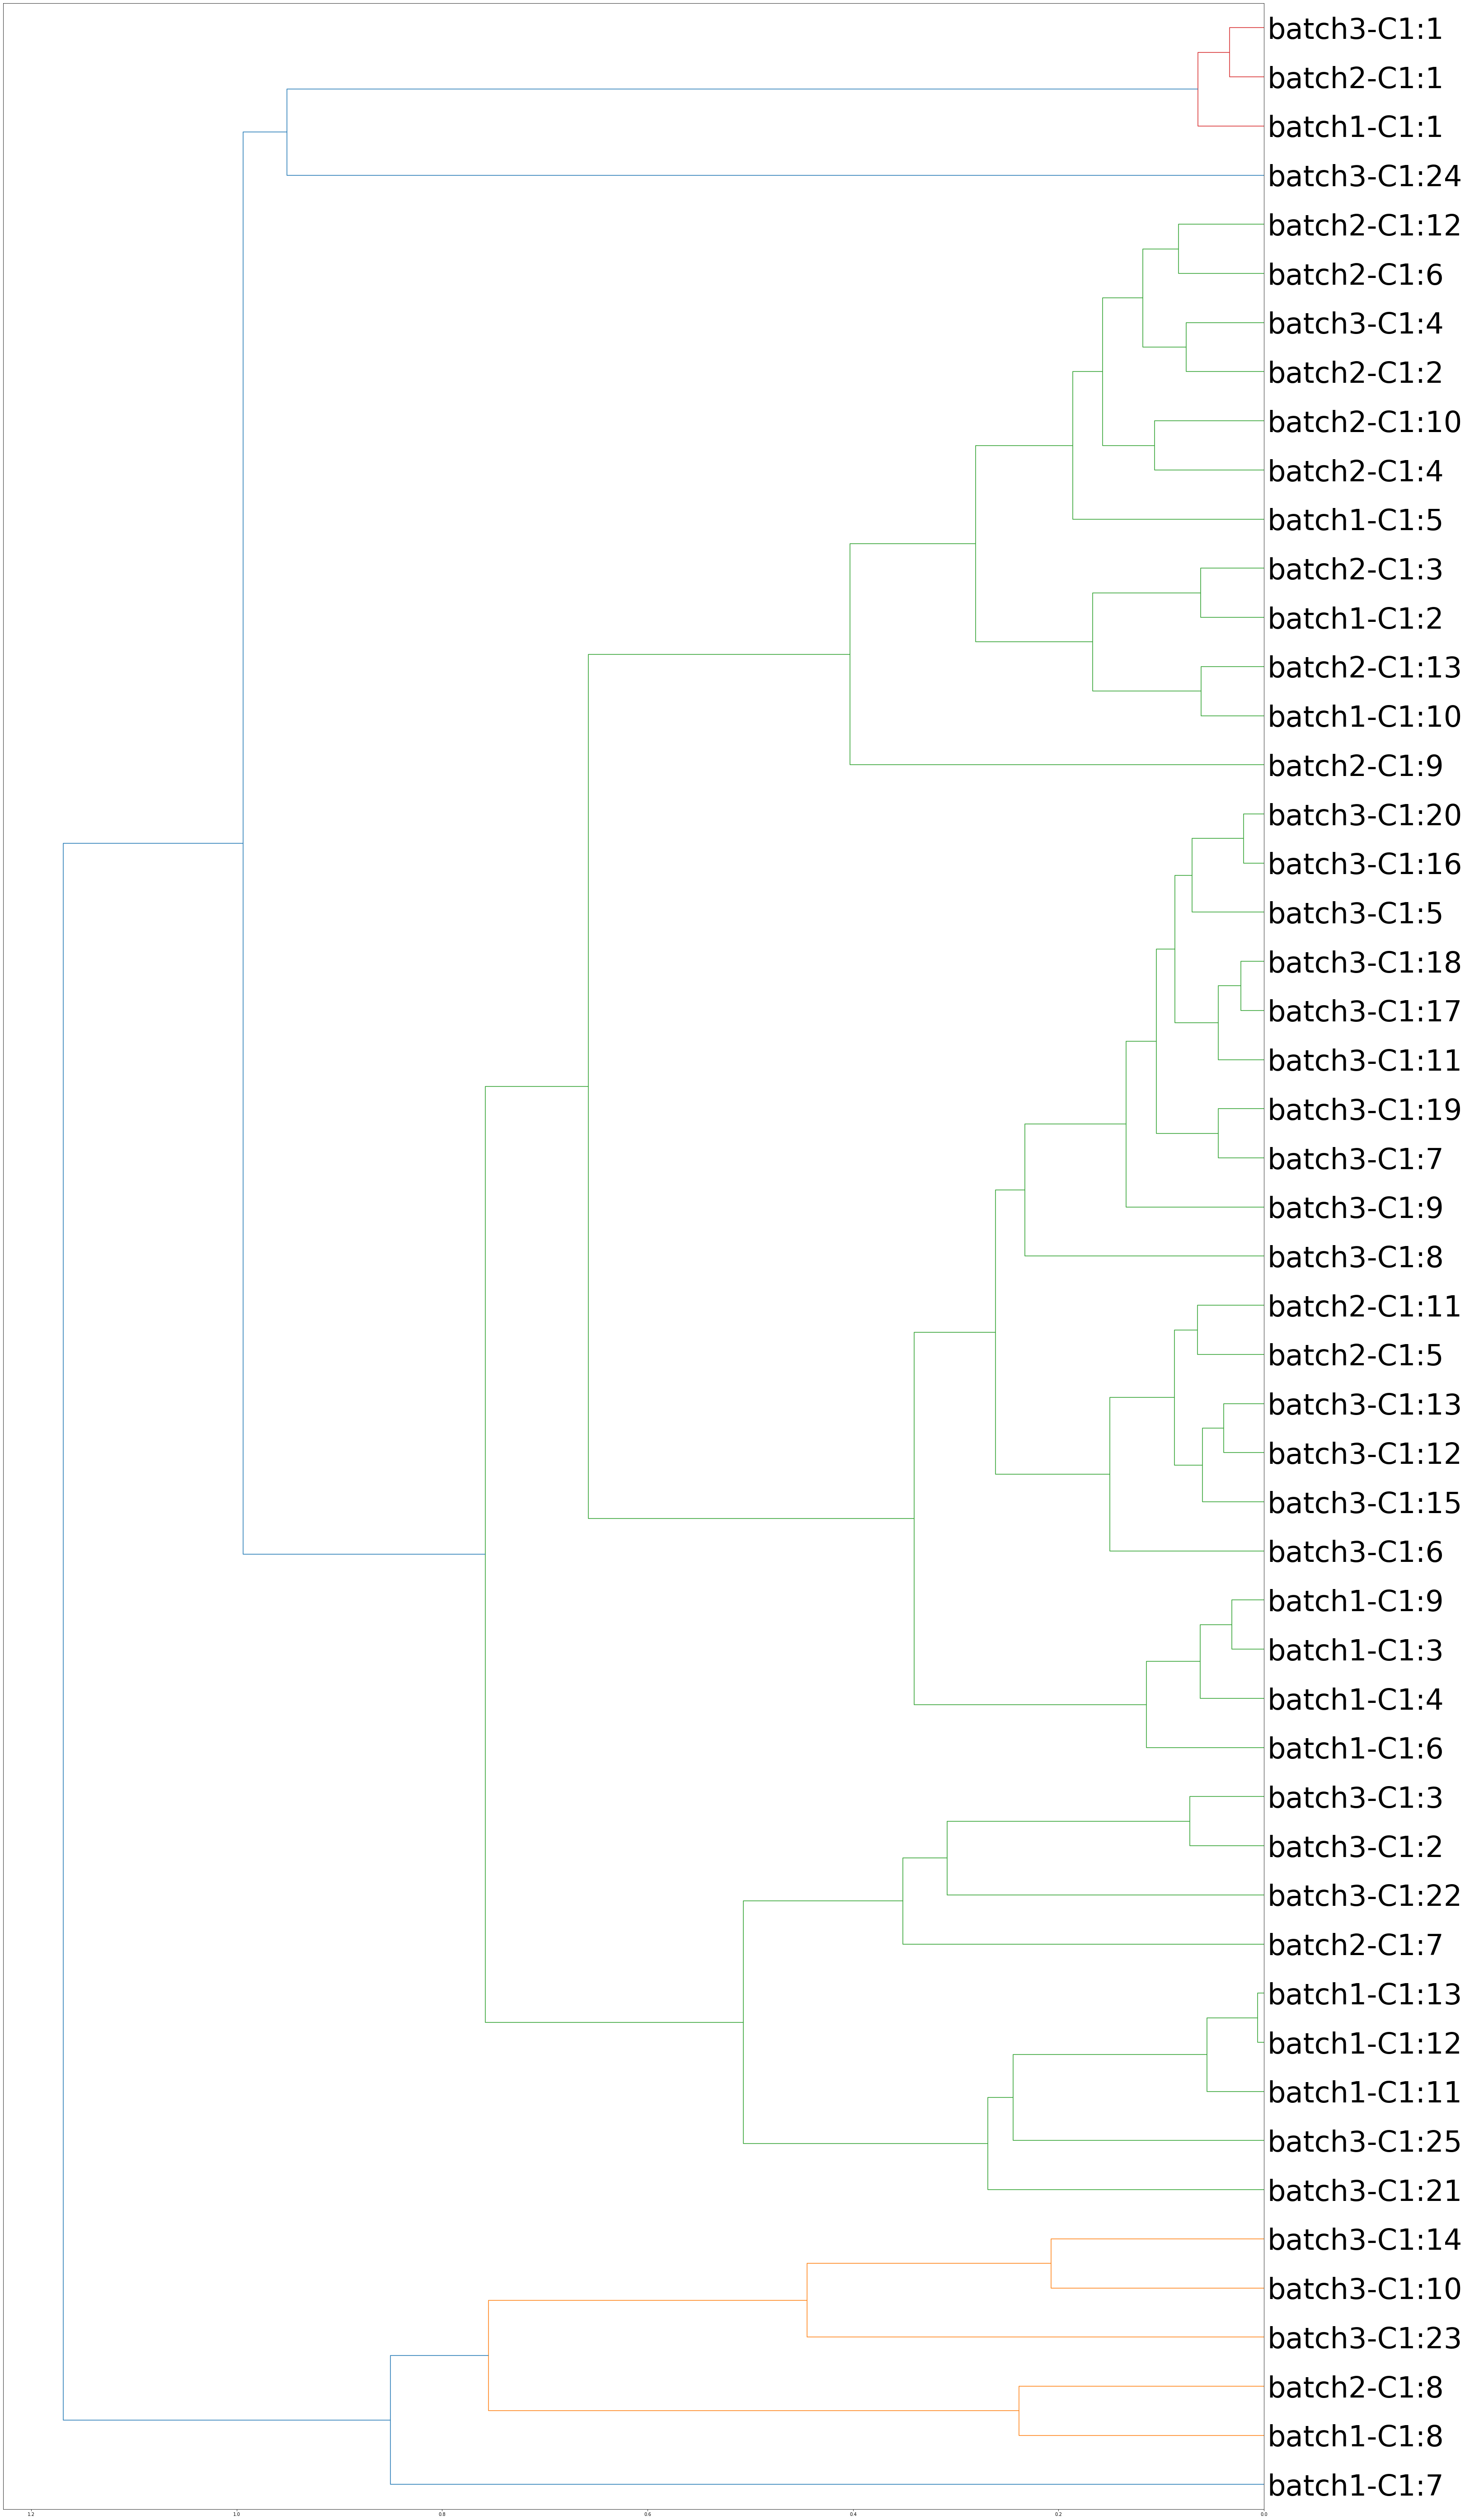

In [62]:
generate_dendogram(newdf)

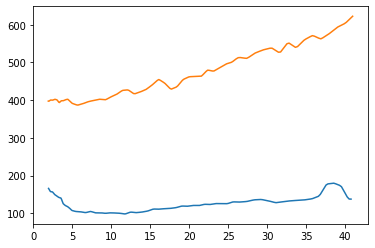

In [64]:
plt.plot(df1['kDa'],df1['C1:8'],df2['kDa'],df2['C1:8'])

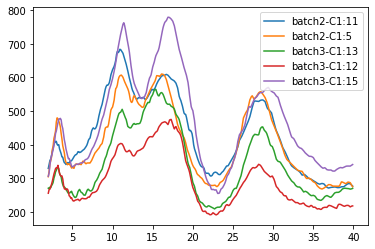

In [73]:
plt.plot(newdf['points'],newdf['batch2-C1:11'],newdf['points'],newdf['batch2-C1:5'],
         newdf['points'],newdf['batch3-C1:13'],newdf['points'],newdf['batch3-C1:12'],
         newdf['points'],newdf['batch3-C1:15'])
plt.legend(['batch2-C1:11','batch2-C1:5','batch3-C1:13','batch3-C1:12','batch3-C1:15'])
plt.savefig('cluster1.png')

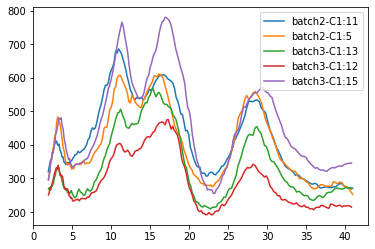

In [77]:
plt.plot(df2['kDa'],df2['C1:11'],df2['kDa'],df2['C1:5'],
         df3['kDa'],df3['C1:13'],df3['kDa'],df3['C1:12'],
         df3['kDa'],df3['C1:15'])
plt.legend(['batch2-C1:11','batch2-C1:5','batch3-C1:13','batch3-C1:12','batch3-C1:15'])
plt.savefig('cluster1b.png')

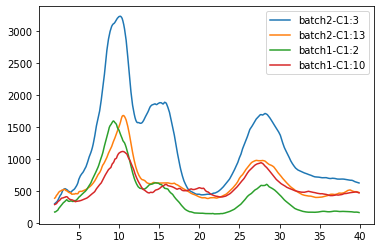

In [74]:
plt.plot(newdf['points'],newdf['batch2-C1:3'],newdf['points'],newdf['batch2-C1:13'],
         newdf['points'],newdf['batch1-C1:2'],newdf['points'],newdf['batch1-C1:10'])
plt.legend(['batch2-C1:3','batch2-C1:13','batch1-C1:2','batch1-C1:10'])
plt.savefig('cluster2.png')

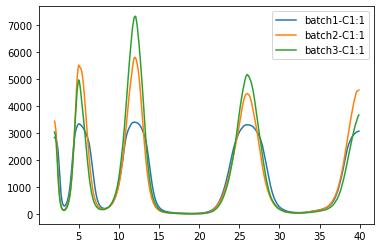

In [75]:
plt.plot(newdf['points'],newdf['batch1-C1:1'],newdf['points'],newdf['batch2-C1:1'],
         newdf['points'],newdf['batch3-C1:1'])
plt.legend(['batch1-C1:1','batch2-C1:1','batch3-C1:1'])
plt.savefig('cluster3.png')